In [14]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
ft_model_directory = "./models/fine_tuned_model/"
PATH_TO_CKPT = os.path.join(os.path.abspath(ft_model_directory), "frozen_inference_graph.pb")
print(PATH_TO_CKPT)
assert os.path.isfile(PATH_TO_CKPT)

# List of the strings that is used to add correct label for each box.
label_directory = "./models/object_detection/data/annotations/"
PATH_TO_LABELS = os.path.join(os.path.abspath(label_directory), "label_map.pbtxt")
#PATH_TO_TEST_IMAGES_DIR =  os.path.join(repo_dir_path, "models/object_detection/data/images/test")
img_directory = "./models/object_detection/data/images/"
PATH_TO_TEST_IMAGES_DIR =  os.path.join(os.path.abspath(img_directory),"test")

assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpeg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

/Users/matt/Workspace/picar/code/models/fine_tuned_model/frozen_inference_graph.pb
['/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.51.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.47.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.50 (1).jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.46.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.50.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.54.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.53.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.49.jpeg', '/Users/matt/Workspace/picar/code/models/object_

In [17]:
#import tensorflow as tf; print(tf.__version__)
%cd ..

/Users/matt/Workspace/picar/code


In [18]:
%cd object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=4, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates 
                # to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict
%cd ..

/Users/matt/Workspace/picar/code/object_detection


Running inferences on ['/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.51.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.47.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.50 (1).jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.46.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.50.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.54.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.53.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.49.jpeg', '/Users/matt/Workspace/picar/code/models/object_detection/data/images/test/photo_2019-12-19 18.59.48.jpeg', '

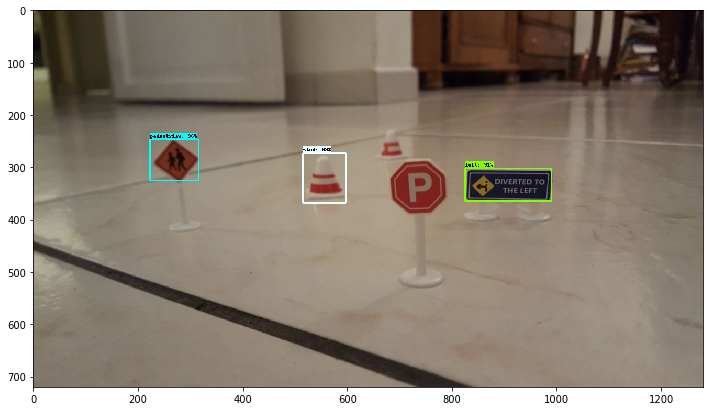

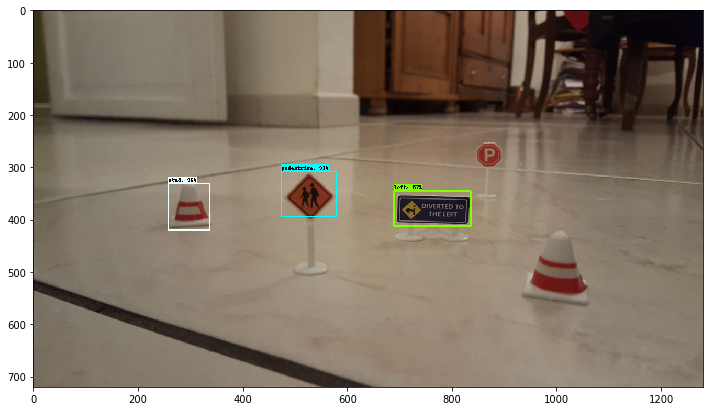

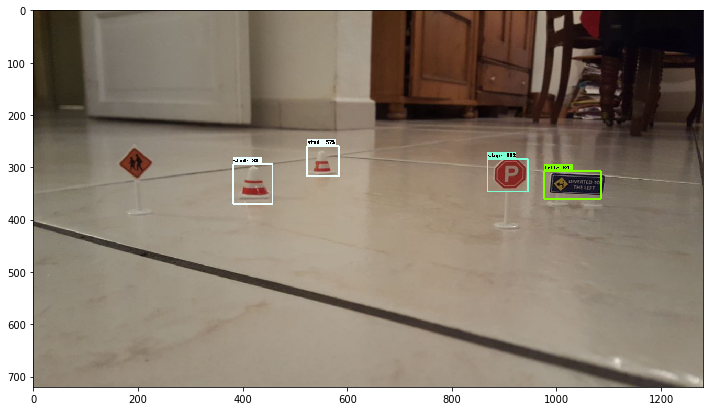

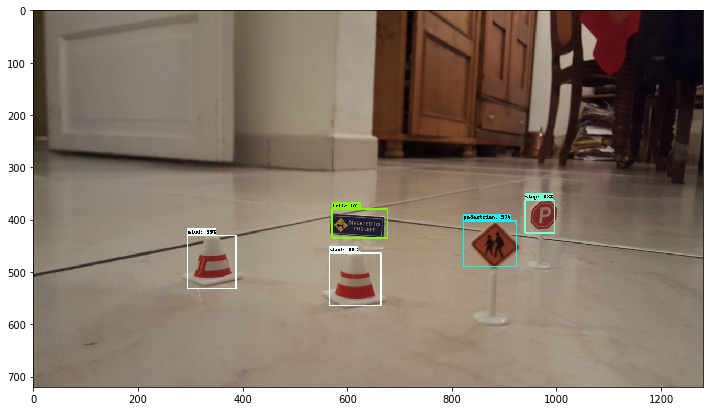

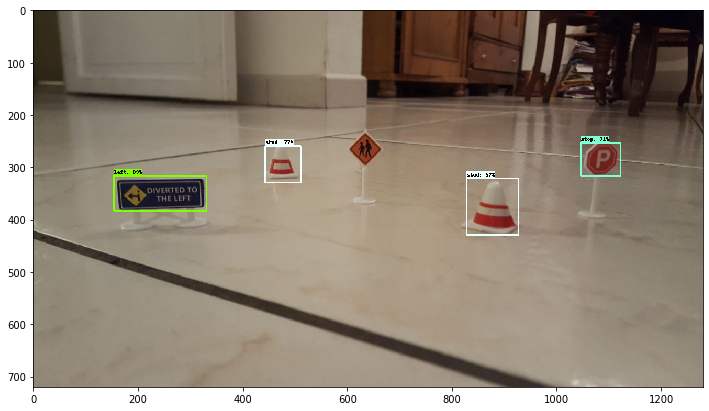

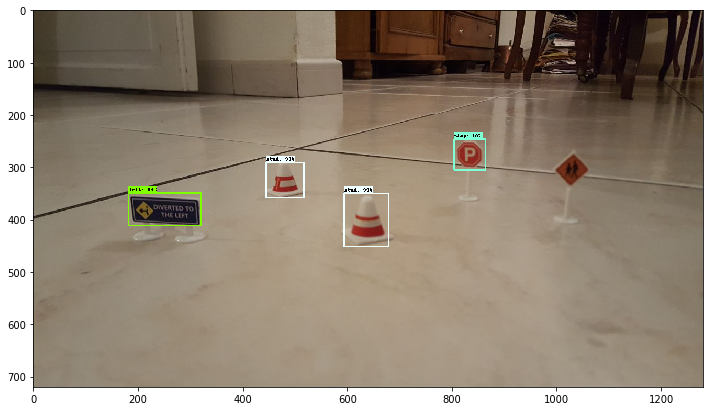

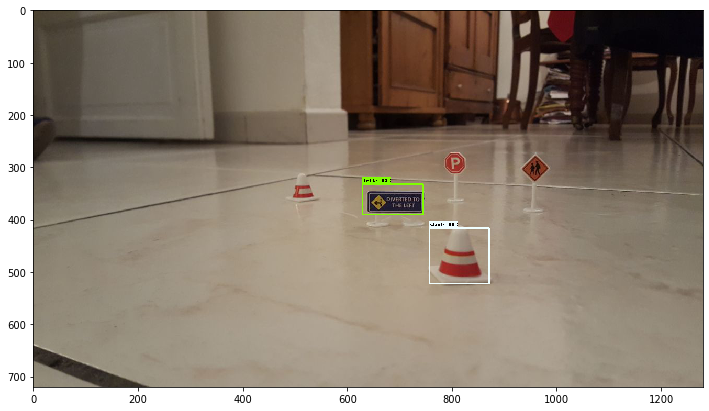

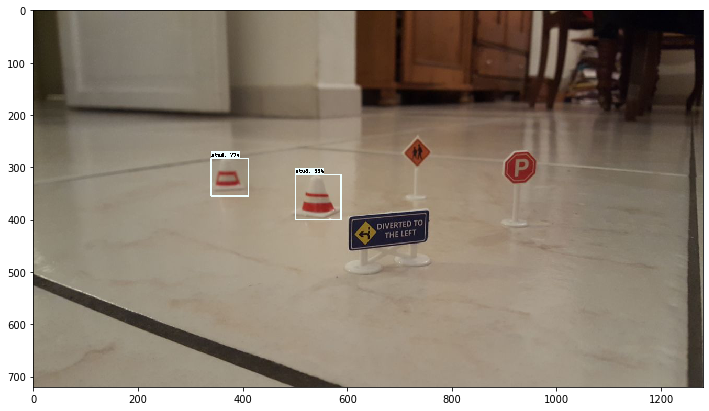

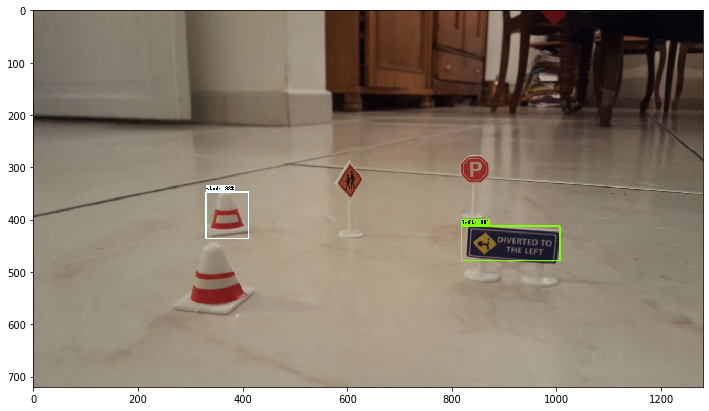

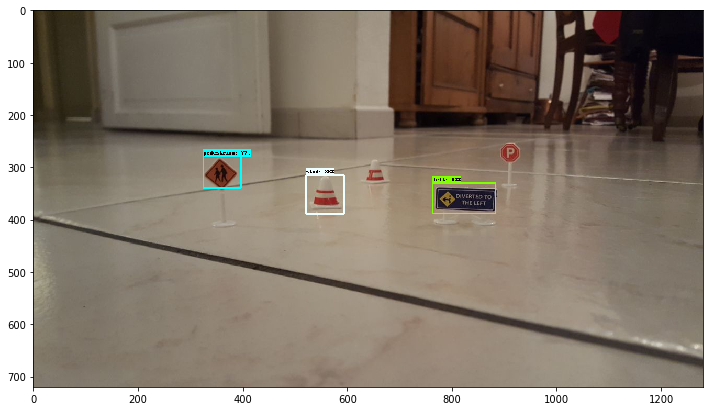

In [21]:
# running inferences.  This should show images with bounding boxes

%matplotlib inline

print('Running inferences on %s' % TEST_IMAGE_PATHS)
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=3)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)